### Imports

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook as tqdm
from os.path import basename, dirname, isdir, isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()

### Settings

In [2]:
CONFIG = {
    "gonogo": {"DUR": 0.5, "OFF": 0.75},
    "conscious": {"DUR": 0.5, "OFF": 0.75},
    # FIXME: nonconscious task sounds harder
}

### OS

In [3]:
def _makedir(dst_dir):
    if not isdir(dst_dir):
        os.makedirs(dst_dir)
        
def _copy(src, dst):
    _makedir(dirname(dst))
    if isfile(dst):
        return
    shutil.copy(src, dst)

### Generate image

In [4]:
def _stim_image(filepath):
    image = mpimg.imread(filepath)
    return image

def _blank_image(filepath):
    shape = _stim_image(filepath).shape
    image = np.zeros(shape)
    return image

### Read stimulus order

In [5]:
def _save(image, dst):
    ### Plotting
    imgplot = plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    ### Saving
    _makedir(dirname(dst))
    plt.savefig(dst)

def _last_onset(onset_df, t):
    tmp = onset_df.copy()
    tmp = tmp[tmp.category != "keypress"].reset_index(drop=True)
    tmp = tmp[tmp["ons"] < t]
    tmp.sort_values("ons", ascending=True, inplace=True)
    if len(tmp) < 1:
        return 0, -100
    return tmp.shape[0] - 1, tmp.iloc[-1]["ons"]

def _load_image(image_path, is_blank, image_cache):
    if is_blank:
        if not "blank" in image_cache:
            image_cache["blank"] = _blank_image(image_path)
        return image_cache["blank"]
    else:
        if not image_path in image_cache:
            image_cache[image_path] = _stim_image(image_path)
        return image_cache[image_path]

### Main

In [15]:
def display_images(root, onset_df, dst_dir, task, fps=4, start_t=0, end_t=308):
    DUR, OFF = CONFIG[task]["DUR"], CONFIG[task]["OFF"]
    N = fps * (end_t - start_t)
    image_cache = {}
    
    stim = pd.read_csv(join(root, "stimulus_order.csv"))
    
    last_image = None
    for i, t in tqdm(enumerate(np.linspace(start_t, end_t, N)), total=N):
        dst = join(dst_dir, "img_%05d.png" % i)
        if not isfile(dst):
            index, last_onset = _last_onset(onset_df, t)
            is_blank   = last_onset + DUR > t
            if is_blank:
#                 image_path = join(root, stim.iloc[index]["stimulus"])
#                 image      = _load_image(image_path, is_blank, image_cache)
#                 _save(image, dst)
                last_image = None
                _copy("/Users/pstetz/Desktop/stimuli/img_00000.png", dst)
            elif last_image is None:
                image_path = join(root, stim.iloc[index]["stimulus"])
                image      = _load_image(image_path, is_blank, image_cache)
                _save(image, dst)
                last_image = dst
            else:
                _copy(last_image, dst)
                last_image = dst

### Create stimuli movie

/Users/pstetz/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


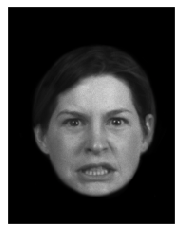

In [16]:
onset_df = pd.read_csv("/Users/pstetz/Desktop/confidential/.project/interpolate/raw/conn152/conscious/onsets.csv")
task = "/Users/pstetz/Desktop/confidential/MRI-SlowMo/img/conscious"
dst_dir = "/Users/pstetz/Desktop/stimuli"
display_images(task, onset_df, dst_dir, "conscious", start_t=200, end_t=270)